In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# get the data
filname = 'drive/facial-recognition/fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df = pd.read_csv('drive/facial-recognition/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [14]:
def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [15]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [16]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [86]:
import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout ,Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
num_labels = 7

In [19]:
def my_model():
    model = Sequential()


    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # 2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # 3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())

    # fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_labels, activation='softmax'))

    # model.summary()

    #Compliling the model
    model.compile(loss=categorical_crossentropy,
                  optimizer=Adam(),
              metrics=['accuracy'])
    
    return model

In [20]:
model=my_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        3

In [21]:
path_model='drive/final-model/expression_recognition_weights.h5' 
model=my_model()

In [23]:
model.load_weights(path_model)

In [22]:
model.evaluate(X_test, y_test)

113/113 [==============================] - 16s 143ms/step - loss: 1.9449 - accuracy: 0.1279


[1.9449443817138672, 0.12789078056812286]

In [25]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [27]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [28]:
y_pred=model.predict(X_test)
#print(y_pred)
y_test.shape

(3589, 7)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


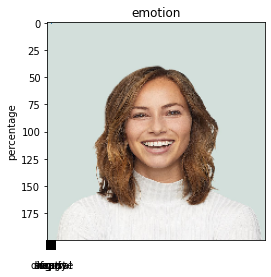

Expression Prediction: happy


In [30]:
from skimage import io
img = image.load_img('drive/hero-happy.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('drive/hero-happy.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

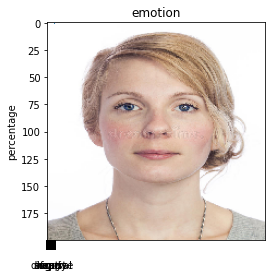

Expression Prediction: neutral


In [83]:
from skimage import io
img = image.load_img('/content/drive/neutral.jpg', color_mode = "grayscale", target_size=(48, 48))
show_img=image.load_img('/content/drive/neutral.jpg', target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

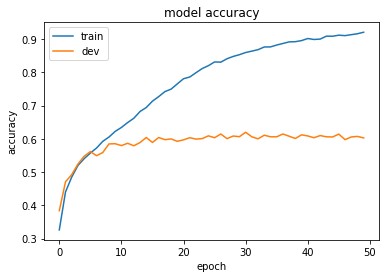

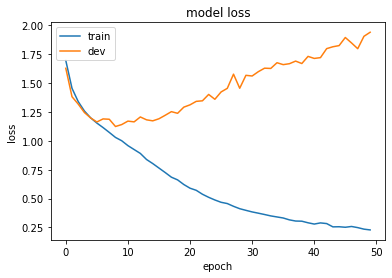

In [82]:
import json

json1_file = open('drive/final-model/model_history.json')
json1_str = json1_file.read()
history = json.loads(json1_str)


plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()